# 反向传播的实现

- 根据链式法则求所有变量的偏导（一元内相乘，多元间相加）
  $$
    \frac{\partial L}{\partial x} = \sum_i \frac{\partial L}{\partial y_i}\frac{\partial y_i}{\partial x}
  $$
- 局部梯度的计算需要知道区分运算，还需要知道运算数
- 必须自己定义一个类用运算符重载和属性实现这些功能（Value）

## 反向传播类

In [1]:
from backward import Value

## 计算图绘制函数

In [2]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._child:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        # if n._op:
        #     # dot.node(name=str(id(n)) + n._op, label=n._op)
        #     dot.node(name=str(id(n)))
        #     # dot.edge(str(id(n)) + n._op, str(id(n)))
        #     dot.edge(str(id(n)), str(id(n)))
    
    for n1, n2 in edges:
        # dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        dot.edge(str(id(n1)), str(id(n2)))
    
    return dot

## 示例

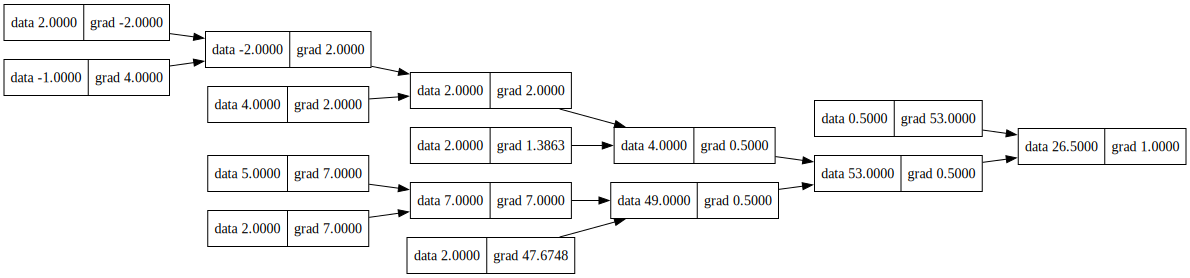

In [3]:
x1 = Value(5)
x2 = Value(2)
loss = ((2 + x1)**2 + (4 - x2)**2) / 2
loss.backward()
draw_dot(loss)

## 线性层的实现

In [4]:
import numpy as np
class Neuron:
    def __init__(self, inNum: int) -> None:
        # 用NumPy数组存储权重（形状：(in_num,)），每个元素是Value类型
        self.weights = np.array([
            Value(np.random.uniform(-1, 1)) 
            for _ in range(inNum)
        ])
        # 偏置（单个Value）
        self.bias = Value(np.random.uniform(-1, 1))
    
    def __call__(self, x: np.ndarray) -> Value:
        # 计算线性部分：z = w·x + b
        weighted_sum = np.sum(self.weights * x) + self.bias
        return weighted_sum
    
    def parameters(self):
        '''
            [w1, w2, ..., b]
        '''
        return list(self.weights) + [self.bias]

class Layer:
    def __init__(self, inNum: int, outNum: int) -> None:
        '''
            inNum: 输入特征数
            outNum: 神经元个数
        '''
        self.neurons = np.array([Neuron(inNum) for _ in range(outNum)])
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
            前向传播：计算层的输出（所有神经元的输出组成的数组）
            out = verctorX @ Layer.W + Layer.b
        """
        # 对每个神经元调用__call__方法，得到输出列表后转为NumPy数组
        out = np.array([neuron(x) for neuron in self.neurons])
        return out
    
    def parameters(self):
        # 遍历每个神经元，收集参数并合并为一个列表
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def zeroGrad(self):
        for n in self.parameters():
            n.data = 0

## 多层感知机

In [7]:
from backward import ActivationFunction, LossFunction, Optimizer, to_one_hot
from data_loader import load_mnist_dataset

numInputs, numOutputs, numHiddens = 784, 10, 256 # 定义模型参数

L1 = Layer(numInputs, numHiddens)
L2 = Layer(numHiddens, numOutputs)

opti = Optimizer(L1.parameters()+L2.parameters(), 0.0001) 

train_images, train_labels, test_images, test_labels = load_mnist_dataset('./data', flatten=True)


In [8]:

for imgIdx in range(train_images.shape[0]):
    img = 1.0 * train_images[imgIdx]
    label = train_labels[imgIdx]

    # 前向传播
    a1 = L1(img)
    a2 = L2(ActivationFunction.RelU(a1))
    yHat = ActivationFunction.softmax(a2)
    
    loss = LossFunction.categorical_cross_entropy(yHat, to_one_hot(label, 10))
    print(f"loss: {loss}")
    opti.zero_grad()
    loss.backward()
    opti.step()


loss: Value(89.09420807823959)
loss: Value(138.6416416408294)
loss: Value(92.08517302948893)
loss: Value(39.305294452171445)
loss: Value(12.215912575075166)
loss: Value(28.779310172711398)
loss: Value(112.50440783445168)
loss: Value(83.24954076826393)
loss: Value(45.56451702293201)
loss: Value(37.94770657765709)
loss: Value(67.07856011665994)
loss: Value(5.464968728707342e-07)
loss: Value(3.03381779172397)
loss: Value(75.80907704390651)
loss: Value(26.82931766659613)
loss: Value(54.00733402078598)
loss: Value(38.1836070988116)
loss: Value(139.58289028435223)
loss: Value(30.642328466391668)
loss: Value(32.762398019168124)
loss: Value(119.9127290114599)
loss: Value(155.81125864193697)
loss: Value(1.2159690827207925)
loss: Value(7.7324004594166045)
loss: Value(95.24297643162814)
loss: Value(57.314015110585665)
loss: Value(77.66450535729224)
loss: Value(3.795437836371665)
loss: Value(95.80069443203587)
loss: Value(72.70916312993432)
loss: Value(10.20769753082426)
loss: Value(237.1694545618

KeyboardInterrupt: 